# Import needed modules

In [1]:
!pip install tensorflow==2.9.1

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


# Data Preprocessing

**Read data and store it in dataframe**

In [3]:
train_dir = '/kaggle/input/covid19-image-dataset/Covid19-dataset/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
train_df

,filepaths,labels
0,/kaggle/input/covid19-image-dataset/Covid19-da...,Normal
1,/kaggle/input/covid19-image-dataset/Covid19-da...,Normal
2,/kaggle/input/covid19-image-dataset/Covid19-da...,Normal
3,/kaggle/input/covid19-image-dataset/Covid19-da...,Normal
4,/kaggle/input/covid19-image-dataset/Covid19-da...,Normal
...,...,...
246,/kaggle/input/covid19-image-dataset/Covid19-da...,Covid
247,/kaggle/input/covid19-image-dataset/Covid19-da...,Covid
248,/kaggle/input/covid19-image-dataset/Covid19-da...,Covid
249,/kaggle/input/covid19-image-dataset/Covid19-da...,Covid


In [5]:
# Generate  test data paths with labels
test_dir = '/kaggle/input/covid19-image-dataset/Covid19-dataset/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
test_df

,filepaths,labels
0,/kaggle/input/covid19-image-dataset/Covid19-da...,Normal
1,/kaggle/input/covid19-image-dataset/Covid19-da...,Normal
2,/kaggle/input/covid19-image-dataset/Covid19-da...,Normal
3,/kaggle/input/covid19-image-dataset/Covid19-da...,Normal
4,/kaggle/input/covid19-image-dataset/Covid19-da...,Normal
...,...,...
61,/kaggle/input/covid19-image-dataset/Covid19-da...,Covid
62,/kaggle/input/covid19-image-dataset/Covid19-da...,Covid
63,/kaggle/input/covid19-image-dataset/Covid19-da...,Covid
64,/kaggle/input/covid19-image-dataset/Covid19-da...,Covid


**Split dataframe into train, valid, and test**

In [7]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

**Create image data generator**

In [8]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 251 validated image filenames belonging to 3 classes.
Found 39 validated image filenames belonging to 3 classes.
Found 27 validated image filenames belonging to 3 classes.


**Show sample from train data**

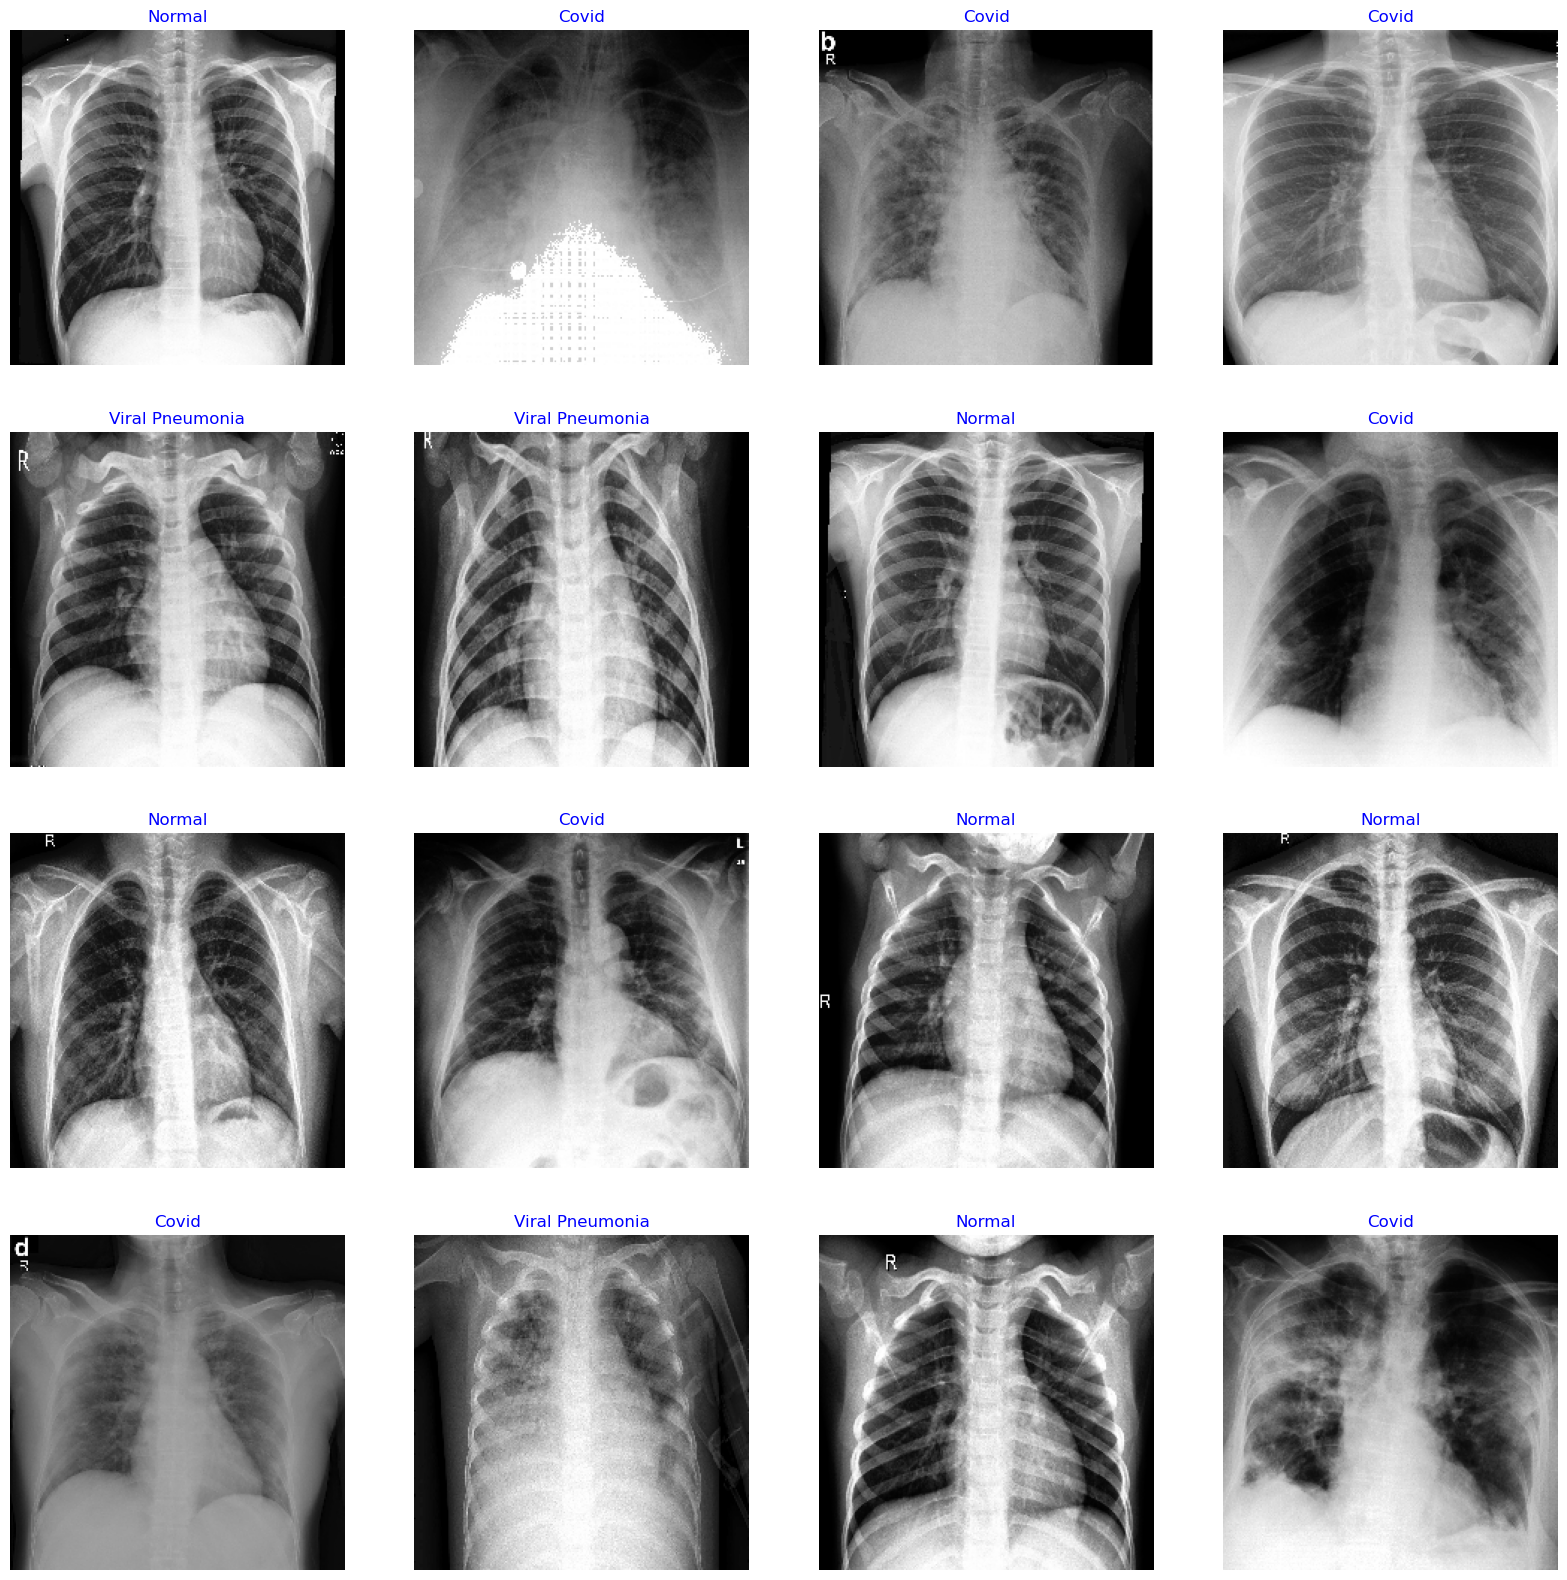

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

**Generic Model Creation**

In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 4,383,398
Trainable params: 4,338,815
Non-trainable params: 44,583
_________________________________________

**Train model**

In [11]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/20
16/16 [==============================] - 19s 547ms/step - loss: 7.9504 - accuracy: 0.8008 - val_loss: 9.6712 - val_accuracy: 0.6154
Epoch 2/20
16/16 [==============================] - 6s 335ms/step - loss: 7.1793 - accuracy: 0.9602 - val_loss: 8.1843 - val_accuracy: 0.7179
Epoch 3/20
16/16 [==============================] - 6s 344ms/step - loss: 6.7368 - accuracy: 0.9681 - val_loss: 7.5143 - val_accuracy: 0.6667
Epoch 4/20
16/16 [==============================] - 5s 336ms/step - loss: 6.3646 - accuracy: 0.9641 - val_loss: 6.8199 - val_accuracy: 0.7436
Epoch 5/20
16/16 [==============================] - 6s 342ms/step - loss: 6.0126 - accuracy: 0.9602 - val_loss: 6.2954 - val_accuracy: 0.7692
Epoch 6/20
16/16 [==============================] - 6s 345ms/step - loss: 5.6756 - accuracy: 0.9602 - val_loss: 5.8711 - val_accuracy: 0.8205
Epoch 7/20
16/16 [==============================] - 6s 350ms/step - loss: 5.3413 - accuracy: 0.9841 - val_loss: 5.5174 - val_accuracy: 0.8974
Epoch

**Display model performance**

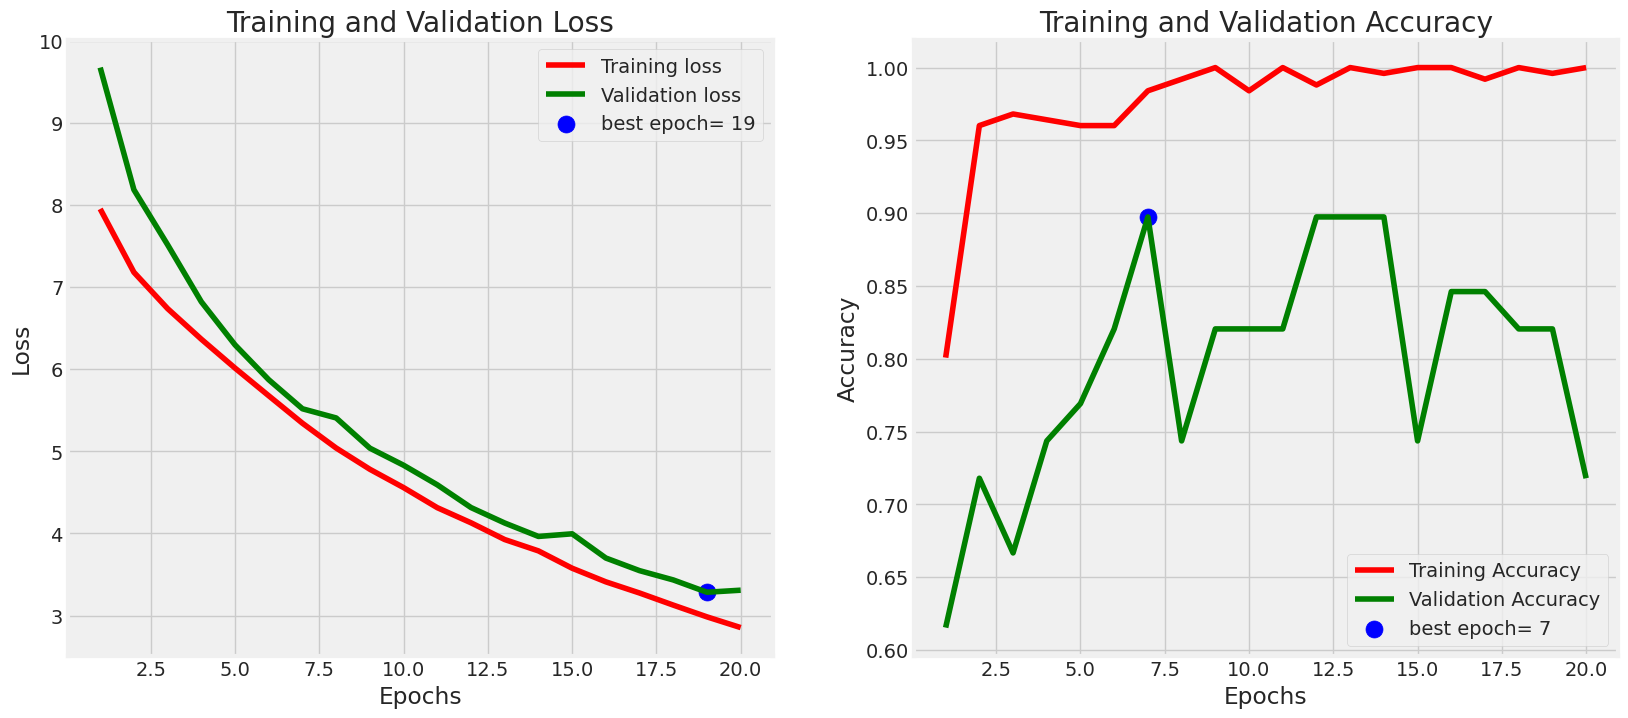

In [12]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

# Evaluate model

In [13]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 0s 198ms/step - loss: 3.0035 - accuracy: 0.9375
Train Loss:  2.8385605812072754
Train Accuracy:  1.0
--------------------
Validation Loss:  3.293531894683838
Validation Accuracy:  0.8125
--------------------
Test Loss:  3.003495216369629
Test Accuracy:  0.9375


**Get Predictions**

In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

**Confusion Matrics and Classification Report**

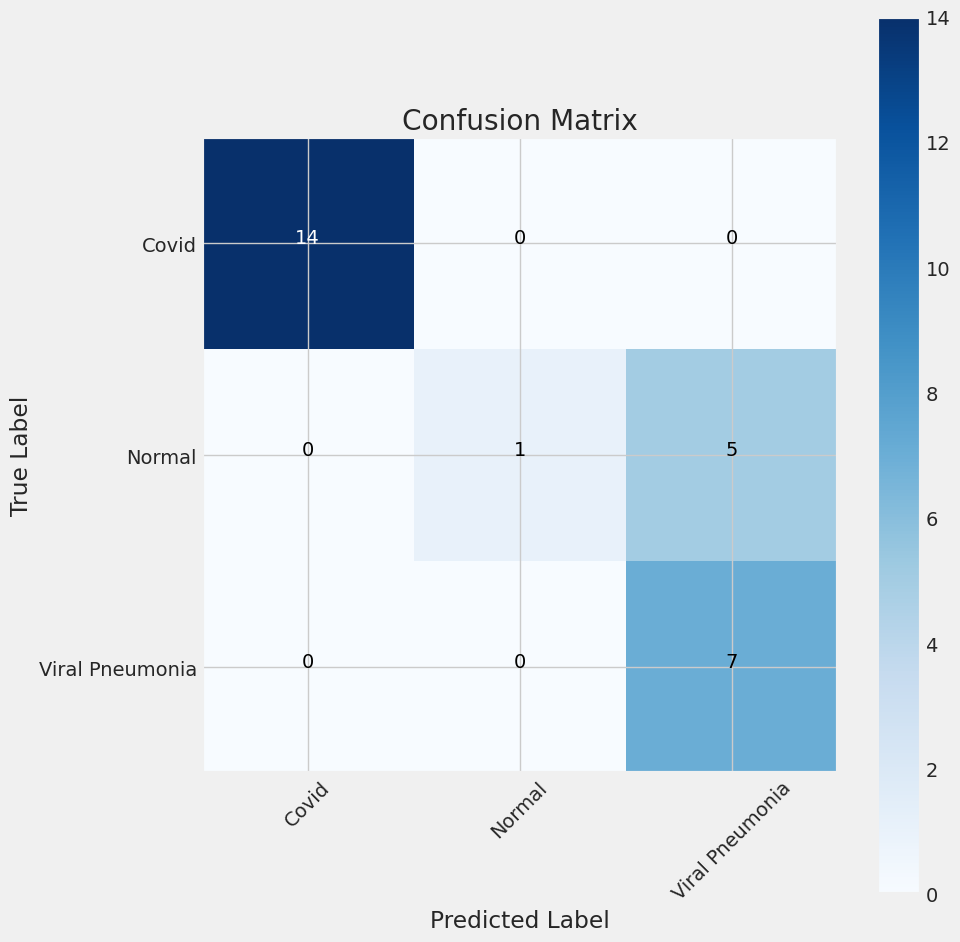

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [16]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        14
         Normal       1.00      0.17      0.29         6
Viral Pneumonia       0.58      1.00      0.74         7

       accuracy                           0.81        27
      macro avg       0.86      0.72      0.67        27
   weighted avg       0.89      0.81      0.77        27



**Save model**

In [17]:
#Save the model
model.save('model.h5')

In [18]:
# Modeli fine-tune ile eğit
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen,
    #callbacks=[early_stopping]
)

# Modeli kaydet (isteğe bağlı)
model.save("/kaggle/working/fine_tuned_model.h5")

# Modeli test et
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(320, 320),
    batch_size=32,
    shuffle=False,  # Doğru değerlendirme için shuffle'ı False yapın
    class_mode='categorical'
)

# Modeli test seti üzerinde değerlendir
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
16/16 [==============================] - 6s 344ms/step - loss: 2.7264 - accuracy: 1.0000 - val_loss: 2.9684 - val_accuracy: 0.8974
Epoch 2/10
16/16 [==============================] - 6s 352ms/step - loss: 2.6492 - accuracy: 0.9801 - val_loss: 2.8472 - val_accuracy: 0.8462
Epoch 3/10
16/16 [==============================] - 6s 354ms/step - loss: 2.5065 - accuracy: 1.0000 - val_loss: 2.8123 - val_accuracy: 0.8462
Epoch 4/10
16/16 [==============================] - 5s 331ms/step - loss: 2.4014 - accuracy: 0.9960 - val_loss: 2.7731 - val_accuracy: 0.7949
Epoch 5/10
16/16 [==============================] - 5s 339ms/step - loss: 2.3097 - accuracy: 0.9960 - val_loss: 2.7298 - val_accuracy: 0.7949
Epoch 6/10
16/16 [==============================] - 6s 336ms/step - loss: 2.2087 - accuracy: 1.0000 - val_loss: 2.5403 - val_accuracy: 0.8205
Epoch 7/10
16/16 [==============================] - 5s 333ms/step - loss: 2.1074 - accuracy: 0.9920 - val_loss: 2.5164 - val_accuracy: 0.7949
Epoch 

NameError: name 'test_generator' is not defined

In [ ]:
# Fine-tune ile eğitilen modelin eğitim geçmişi
fine_tune_epochs = len(history.history['accuracy'])
fine_tune_epochs_range = range(1, fine_tune_epochs + 1)

# Eğitim ve doğrulama (validation) loss değerleri
fine_tune_train_loss = history.history['loss']
fine_tune_val_loss = history.history['val_loss']

# Eğitim ve doğrulama (validation) accuracy değerleri
fine_tune_train_acc = history.history['accuracy']
fine_tune_val_acc = history.history['val_accuracy']

# Grafik çizimi
plt.figure(figsize=(14, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(fine_tune_epochs_range, fine_tune_train_loss, 'r', label='Fine-tune Training Loss')
plt.plot(fine_tune_epochs_range, fine_tune_val_loss, 'g', label='Fine-tune Validation Loss')
plt.title('Fine-tune Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(fine_tune_epochs_range, fine_tune_train_acc, 'r', label='Fine-tune Training Accuracy')
plt.plot(fine_tune_epochs_range, fine_tune_val_acc, 'g', label='Fine-tune Validation Accuracy')
plt.title('Fine-tune Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Prediction using loaded_model

In [ ]:
loaded_model = tf.keras.models.load_model('/kaggle/working/model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Covid/0102.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

In [ ]:
# Test seti için veri akışı oluştur
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(320, 320),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

# Modeli test seti üzerinde değerlendir
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Define needed variables
tr_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history with custom styles
plt.figure(figsize=(12, 5))
plt.style.use('fivethirtyeight')

# Define acc_label here
acc_label = f'best epoch= {str(index_acc + 1)}'  # Adjust here to display 1-based epoch

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, linestyle='-', color='darkred', marker='o', label='Training Accuracy')
plt.plot(Epochs, val_acc, linestyle='-', color='darkgreen', marker='s', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', marker='D', label=acc_label)
plt.plot(Epochs, [test_accuracy] * len(Epochs), linestyle='-', color='navy', marker='D', label='Test Accuracy')  # Eklenen kısım
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Modelin test seti üzerinde tahminleri
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# Classification report
print(classification_report(test_generator.classes, y_pred, target_names=classes))


In [ ]:
# Modeli test seti üzerinde değerlendir
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Get Predictions
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

# Confusion Matrics and Classification Report
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(test_generator.classes, y_pred, target_names=classes))


If you found it helpful, do upvote

Feel free to comment

I would love to have suggestions.